# Challenge Deep Learning

L'objectif de ce challenge est de proposer une méthode de classification, basée sur des réseaux de neurones, permettant de classer des images de champignons.
Le jeu de données proposé comprend 3 classes balancées

Vous pouvez utiliser tout algorithme qui vous semble pertinent (PMC, CNN,), en faisant varier les données d'entrée (normalisation, augmentation de données,...), les paramètres des réseaux considérés (fonction objectif, optimiseur, dropout, learning rate, taille des batchs...)

Vous devez prendre en compte la spécificité des données (peu d'exemples, images de tailles différentes,...) pour construire vos jeux d'apprentissage et de test.

Bien sûr, pour valider votre travail, nous ferons tourner le code en local, sur une base que nous conservons, pour voir si les résultats que vous proposez sont reproductibles. 

Le compte-rendu sera effectué sur un notebook jupyter, dans lequel vous reporterez votre méthodologie en markdown, et vos codes en Python. Vous **expliquerez votre démarche**, **justifierez vos choix**, **commenterez vos expérimentations et vos résultats**.

La notation sera construite de la manière suivante : 
- 12 points sur le compte-rendu
- 8 points seront accordés sur un classement par le taux de reconnsaissance des objets de la base de test. 

Le notebook sera déposé sur la plateforme moodle du cours.

In [10]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [11]:
def Data():
    # Chemin principal des datasets
    base_dir = "mushrooms"
    test_dir = "test_mushrooms"
    
    # Répertoires pour les ensembles d'entraînement et de test
    train_dir = os.path.join(base_dir)
    test_dir = os.path.join(test_dir)
    
    # Classes (catégories)
    train_classes = os.listdir(train_dir)
    test_classes = os.listdir(test_dir)

    
    print("Classes d'entraînement:", train_classes)
    print("Classes de test:", test_classes)
    
    # Vérification des classes identiques entre train et test
    if set(train_classes) != set(test_classes):
        print("Attention : Les classes dans les ensembles d'entraînement et de test ne correspondent pas !")
    


    # Chargement des fichiers
    train_data = []
    for label in train_classes:
        # Exclure le dossier test
        image_files = os.listdir(os.path.join(train_dir, label))
        train_data.extend([(label, os.path.join(train_dir, label, f)) for f in image_files])
    
    test_data = []
    for label in test_classes:
        image_files = os.listdir(os.path.join(test_dir, label))
        test_data.extend([(label, os.path.join(test_dir, label, f)) for f in image_files])
    
    # Informations générales
    print("Nombre total d'images d'entraînement:", len(train_data))
    print("Nombre total d'images de test:", len(test_data))
    print("Nombre d'images par classe dans l'ensemble d'entraînement:",
          {label: len(os.listdir(os.path.join(train_dir, label))) for label in train_classes if label != "test"})
    print("Nombre d'images par classe dans l'ensemble de test:",
          {label: len(os.listdir(os.path.join(test_dir, label))) for label in test_classes})
    
    return train_data, test_data

In [12]:
train_data, test_data = Data()

Classes d'entraînement: ['amanita', 'crimini', 'oyster']
Classes de test: ['amanita', 'crimini', 'oyster']
Nombre total d'images d'entraînement: 17692
Nombre total d'images de test: 1640
Nombre d'images par classe dans l'ensemble d'entraînement: {'amanita': 5879, 'crimini': 5873, 'oyster': 5940}
Nombre d'images par classe dans l'ensemble de test: {'amanita': 535, 'crimini': 561, 'oyster': 544}


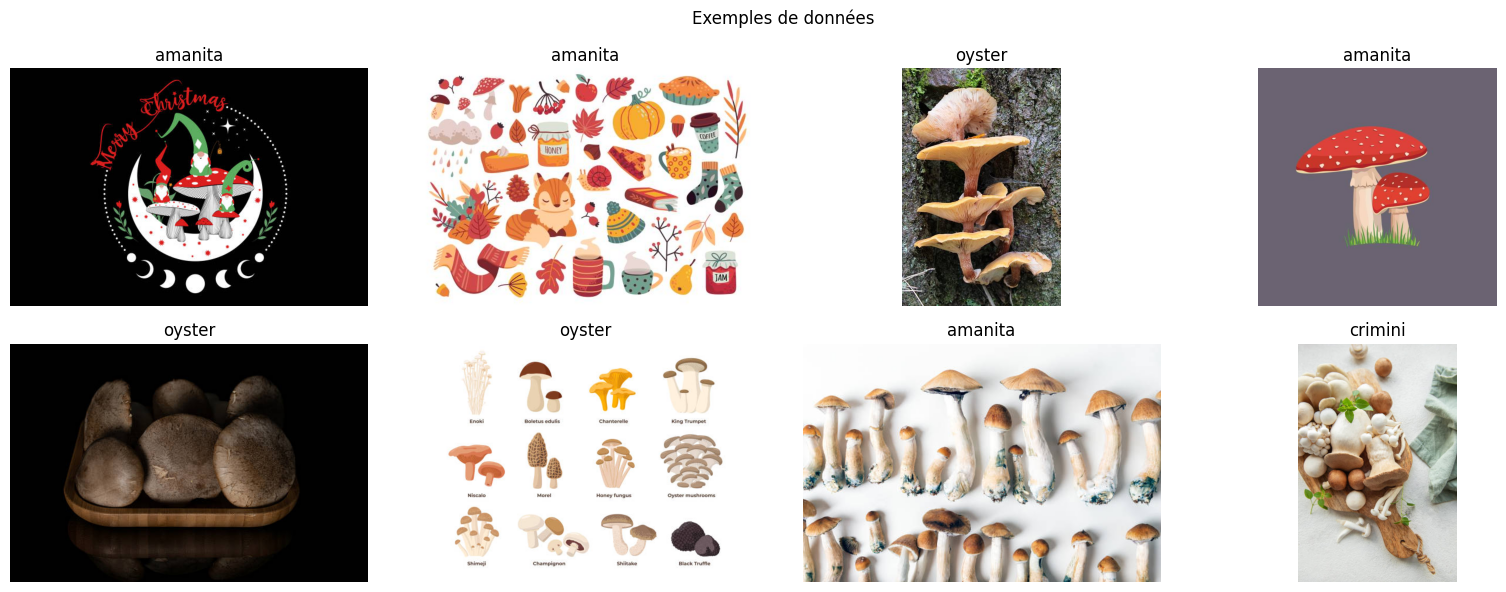

In [13]:
image_samples = np.random.randint(0,high=len(train_data)-1, size=8)

fig = plt.figure(figsize=(16,6))
for i,img_idx in enumerate(image_samples):
    axs = fig.add_subplot(2,4,i+1)
    axs.set_title(train_data[img_idx][0])
    image = Image.open(train_data[img_idx][1])
    plt.imshow(image)
    plt.axis('off')

plt.suptitle("Exemples de données")
plt.tight_layout()

## Generation de variation d'image

In [14]:
# Dimensions des images
IMG_HEIGHT = 128
IMG_WIDTH = 128
BATCH_SIZE = 32

# Générateur de données pour l'entraînement et la validation
train_datagen = ImageDataGenerator(
    rescale=1.0/255,       # Normalisation des pixels (0-1)
    rotation_range=20,     # Rotation aléatoire des images
    width_shift_range=0.2, # Décalage horizontal
    height_shift_range=0.2,# Décalage vertical
    shear_range=0.2,       # Transformation en cisaillement
    zoom_range=0.2,        # Zoom
    horizontal_flip=True,  # Flip horizontal
    fill_mode='nearest'    # Mode de remplissage
)

test_datagen = ImageDataGenerator(rescale=1.0/255)  # Normalisation uniquement

# Préparation des ensembles d'entraînement et de test
train_dir = "mushrooms"  # Chemin des données d'entraînement
test_dir = "test_mushrooms"  # Chemin des données de test

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'  # Plusieurs classes
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 17692 images belonging to 3 classes.
Found 1640 images belonging to 3 classes.


## Model

In [15]:
def create_cnn_model(input_shape, num_classes):
    model = Sequential()

    # Bloc de convolution 1
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Bloc de convolution 2
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Bloc de convolution 3
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Flatten + Fully Connected Layers
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))  # Régularisation
    model.add(Dense(num_classes, activation='softmax'))  # Couches de sortie

    return model

# Création du modèle
input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)  # Images en couleur
num_classes = train_generator.num_classes
model = create_cnn_model(input_shape, num_classes)

# Compilation du modèle
model.compile(
    optimizer='adam', 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

# Résumé du modèle
model.summary()


/home/xerneas02/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,027 (12.61 MB)

 Trainable params: 3,305,027 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

## Train

In [16]:
# Entraînement du modèle
EPOCHS = 20
print("GPU disponible :", tf.config.list_physical_devices('GPU'))

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=test_generator
)

GPU disponible : [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


/home/xerneas02/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


E0000 00:00:1733164095.070895     634 cuda_dnn.cc:522] Loaded runtime CuDNN library: 9.1.0 but source was compiled with: 9.3.0.  CuDNN library needs to have matching major version and equal or higher minor version. If using a binary install, upgrade your CuDNN library.  If building from sources, make sure the library loaded at runtime is compatible with the version specified during compile configuration.
E0000 00:00:1733164095.135224     634 cuda_dnn.cc:522] Loaded runtime CuDNN library: 9.1.0 but source was compiled with: 9.3.0.  CuDNN library needs to have matching major version and equal or higher minor version. If using a binary install, upgrade your CuDNN library.  If building from sources, make sure the library loaded at runtime is compatible with the version specified during compile configuration.
2024-12-02 19:28:15.140918: W tensorflow/core/framework/op_kernel.cc:1841] OP_REQUIRES failed at xla_ops.cc:577 : FAILED_PRECONDITION: DNN library initialization failed. Look at the er

FailedPreconditionError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/home/xerneas02/.local/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/xerneas02/.local/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/xerneas02/.local/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/xerneas02/.local/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/home/xerneas02/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/home/xerneas02/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/home/xerneas02/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/xerneas02/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/home/xerneas02/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/home/xerneas02/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/home/xerneas02/.local/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/xerneas02/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/home/xerneas02/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/home/xerneas02/.local/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/home/xerneas02/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/home/xerneas02/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/home/xerneas02/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/tmp/ipykernel_355/3156860243.py", line 5, in <module>

  File "/home/xerneas02/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/xerneas02/.local/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 320, in fit

  File "/home/xerneas02/.local/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 121, in one_step_on_iterator

DNN library initialization failed. Look at the errors above for more details.
	 [[{{node StatefulPartitionedCall}}]] [Op:__inference_one_step_on_iterator_4220]

## Test

In [ ]:
# Évaluation sur les données de test
test_loss, test_acc = model.evaluate(test_generator)
print(f"Précision sur l'ensemble de test: {test_acc:.2f}")

# Visualisation des courbes de précision et de perte
plt.figure(figsize=(12, 4))

# Courbe de précision
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entraînement')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Précision')
plt.xlabel('Épochs')
plt.ylabel('Précision')
plt.legend()

# Courbe de perte
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entraînement')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Perte')
plt.xlabel('Épochs')
plt.ylabel('Perte')
plt.legend()

plt.tight_layout()
plt.show()